<a href="https://colab.research.google.com/github/ahsanulSowmik/AnalyzeCode/blob/main/dataPreprocessingOfBatteryDataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# STEP 1: Upload your file
from google.colab import files
uploaded = files.upload()

Saving 2017-05-12_6C-50per_3_6C_CH36.csv to 2017-05-12_6C-50per_3_6C_CH36.csv


BATTERY DATA PREPROCESSING PIPELINE
Original data shape: (919045, 15)

=== Missing Values ===
                     Missing_Count  Percentage
Data_Point                  906605   98.646421
Test_Time                   906605   98.646421
DateTime                    906605   98.646421
Step_Time                   906605   98.646421
Step_Index                  906605   98.646421
Cycle_Index                 906605   98.646421
Current                     906605   98.646421
Voltage                     906605   98.646421
Charge_Capacity             906605   98.646421
Discharge_Capacity          906605   98.646421
Charge_Energy               906605   98.646421
Discharge_Energy            906605   98.646421
dV/dt                       906605   98.646421
Internal_Resistance         906605   98.646421
Temperature                 906605   98.646421

=== Removing Duplicates ===
Rows before: 919045
Rows after: 12441
Duplicates removed: 906604

=== Handling Missing Values (method: interpolate) ===
Missi

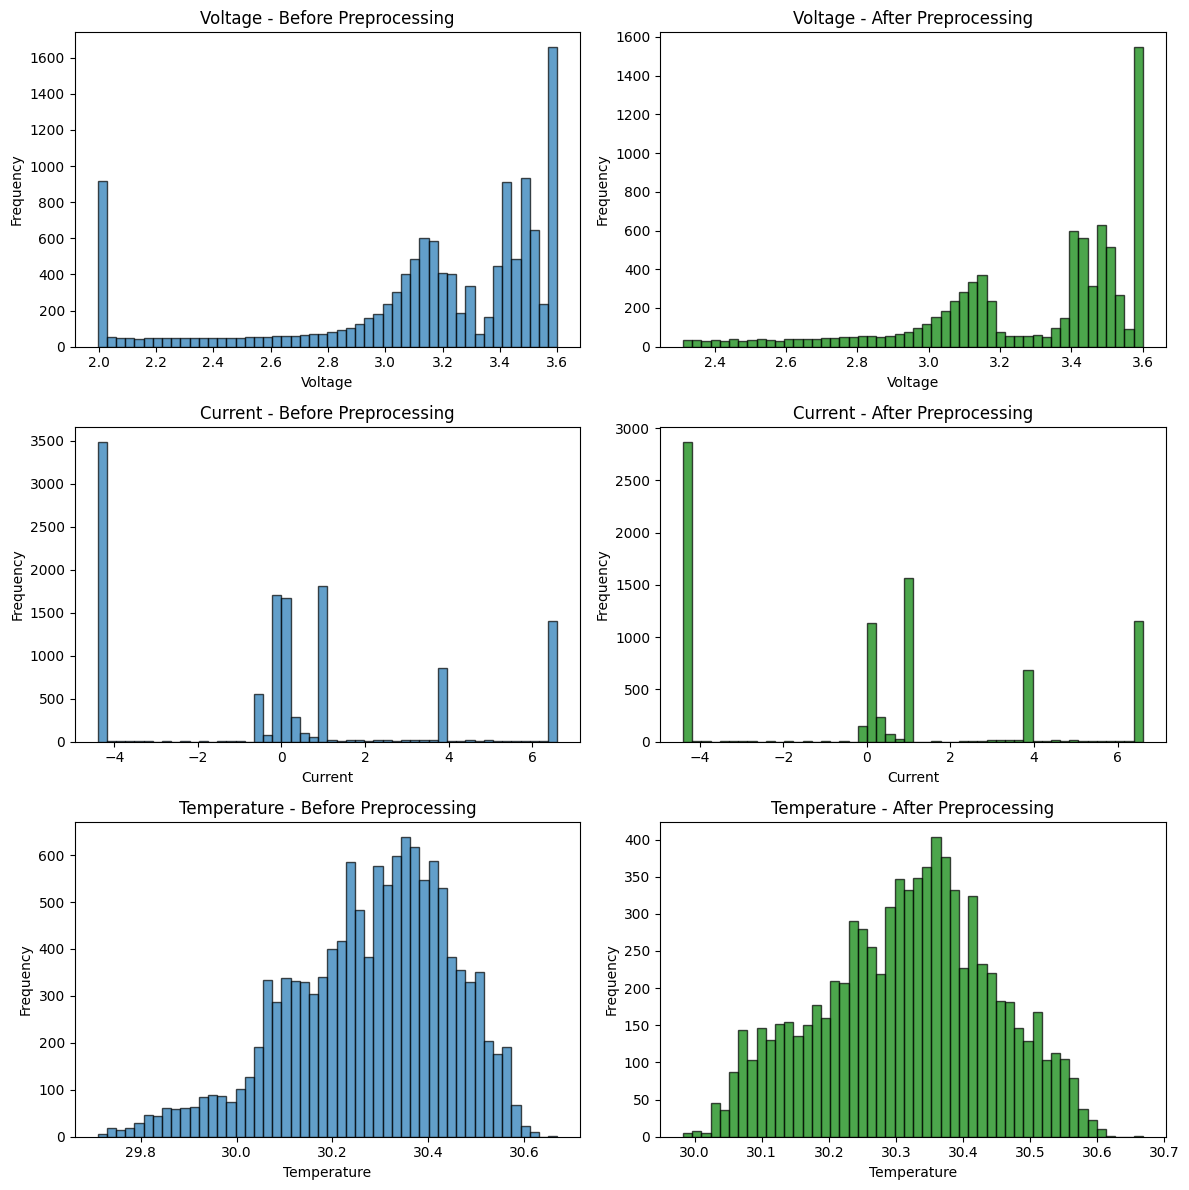


=== Sample of Cleaned Data ===
   Data_Point   Test_Time      DateTime  Step_Time  Step_Index  Cycle_Index  \
0      3129.0  10829.8496  1.494734e+09     0.7229         8.0          1.0   
1      3130.0  10834.8836  1.494734e+09     5.0066         9.0          1.0   
2      3131.0  10834.8837  1.494734e+09     5.0067         9.0          1.0   
3      3132.0  10839.8771  1.494734e+09    10.0001         9.0          1.0   
4      3133.0  10839.8772  1.494734e+09    10.0002         9.0          1.0   
5      3134.0  10844.8784  1.494734e+09    15.0014         9.0          1.0   
6      3135.0  10844.8785  1.494734e+09    15.0015         9.0          1.0   
7      3136.0  10849.8819  1.494734e+09    20.0049         9.0          1.0   
8      3137.0  10854.8865  1.494734e+09    25.0095         9.0          1.0   
9      3138.0  10854.8866  1.494734e+09    25.0096         9.0          1.0   

    Current   Voltage  Charge_Capacity  Discharge_Capacity  Charge_Energy  \
0 -0.000249  3.295767

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
def load_data(filepath):
    """Load battery cycling data from TSV/CSV file"""
    df = pd.read_csv(filepath, sep=',')  # Changed to comma for CSV
    print(f"Original data shape: {df.shape}")
    return df

# 1. Check for missing values
def check_missing_values(df):
    """Identify missing values in the dataset"""
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Percentage': missing_pct
    })
    print("\n=== Missing Values ===")
    print(missing_df[missing_df['Missing_Count'] > 0])
    return missing_df

# 2. Remove duplicate rows
def remove_duplicates(df):
    """Remove duplicate rows based on Test_Time"""
    print(f"\n=== Removing Duplicates ===")
    print(f"Rows before: {len(df)}")

    # Remove duplicates based on Test_Time
    df_no_dup = df.drop_duplicates(subset=['Test_Time'], keep='first')

    print(f"Rows after: {len(df_no_dup)}")
    print(f"Duplicates removed: {len(df) - len(df_no_dup)}")

    return df_no_dup

# 3. Handle missing values
def handle_missing_values(df, method='interpolate'):
    """Handle missing values using different methods"""
    print(f"\n=== Handling Missing Values (method: {method}) ===")

    df_filled = df.copy()

    if method == 'drop':
        df_filled = df_filled.dropna()
    elif method == 'mean':
        df_filled = df_filled.fillna(df_filled.mean(numeric_only=True))
    elif method == 'median':
        df_filled = df_filled.fillna(df_filled.median(numeric_only=True))
    elif method == 'interpolate':
        numeric_cols = df_filled.select_dtypes(include=[np.number]).columns
        df_filled[numeric_cols] = df_filled[numeric_cols].interpolate(method='linear')
    elif method == 'forward_fill':
        df_filled = df_filled.ffill()
    elif method == 'backward_fill':
        df_filled = df_filled.bfill()

    print(f"Missing values after handling: {df_filled.isnull().sum().sum()}")

    return df_filled

# 4. Detect and remove outliers using IQR method
def remove_outliers_iqr(df, columns, threshold=1.5):
    """Remove outliers using IQR method"""
    print(f"\n=== Removing Outliers (IQR method, threshold={threshold}) ===")
    print(f"Rows before: {len(df)}")

    df_clean = df.copy()

    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
        print(f"{col}: {outliers} outliers detected (range: [{lower_bound:.4f}, {upper_bound:.4f}])")

        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    print(f"Rows after: {len(df_clean)}")
    print(f"Total rows removed: {len(df) - len(df_clean)}")

    return df_clean

# 5. Sort data
def sort_data(df, by_column='Test_Time'):
    """Sort data by specified column"""
    print(f"\n=== Sorting Data by {by_column} ===")
    df_sorted = df.sort_values(by=by_column).reset_index(drop=True)
    return df_sorted

# 6. Generate statistical summary
def generate_summary(df):
    """Generate comprehensive statistical summary"""
    print("\n=== Statistical Summary ===")
    print("\nDescriptive Statistics:")
    print(df.describe())

    print("\nData Types:")
    print(df.dtypes)

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numeric_cols].corr()

    return corr_matrix

# 7. Visualize data
def visualize_preprocessing(df_before, df_after, columns):
    """Create visualization comparing before and after preprocessing"""
    fig, axes = plt.subplots(len(columns), 2, figsize=(12, 4*len(columns)))

    for i, col in enumerate(columns):
        # Before
        axes[i, 0].hist(df_before[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[i, 0].set_title(f'{col} - Before Preprocessing')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Frequency')

        # After
        axes[i, 1].hist(df_after[col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
        axes[i, 1].set_title(f'{col} - After Preprocessing')
        axes[i, 1].set_xlabel(col)
        axes[i, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Main preprocessing pipeline
def preprocess_battery_data(filepath, output_path='preprocessed_data.csv'):
    """Complete preprocessing pipeline for battery cycling data"""
    print("="*60)
    print("BATTERY DATA PREPROCESSING PIPELINE")
    print("="*60)

    # Load data
    df = load_data(filepath)
    df_original = df.copy()

    # Check missing values
    check_missing_values(df)

    # Remove duplicates
    df = remove_duplicates(df)

    # Handle missing values
    df = handle_missing_values(df, method='interpolate')

    # Remove outliers for key columns
    outlier_columns = ['Current', 'Voltage', 'Charge_Capacity',
                       'Discharge_Capacity', 'Temperature', 'Internal_Resistance']
    df = remove_outliers_iqr(df, outlier_columns, threshold=1.5)

    # Sort data chronologically
    df = sort_data(df, by_column='Test_Time')

    # Generate summary statistics
    corr_matrix = generate_summary(df)

    # Save preprocessed data
    df.to_csv(output_path, index=False)
    print(f"\n=== Preprocessed data saved to '{output_path}' ===")
    print(f"Final shape: {df.shape}")

    # Visualize results
    viz_columns = ['Voltage', 'Current', 'Temperature']
    visualize_preprocessing(df_original, df, viz_columns)

    return df, corr_matrix


# RUN THE PREPROCESSING
filepath = '/content/2017-05-12_6C-50per_3_6C_CH36.csv'  # Colab path
df_clean, corr_matrix = preprocess_battery_data(filepath)

# Display sample of cleaned data
print("\n=== Sample of Cleaned Data ===")
print(df_clean.head(10))

print("\n=== Data Info ===")
print(df_clean.info())
